In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from torch import nn
from torchlake.few_shot.controllers.trainer_episode import EpisodeTrainer
from torchlake.few_shot.controllers.evaluator_episode import EpisodeEvaluator
from torchlake.few_shot.datasets.omniglot import OmniglotSet, TRAIN_LANGUAGES, TEST_LANGUAGES
from torchlake.few_shot.models.relation import RelationNet
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 28
EPISODE_SIZE = 1000

In [3]:
artifact_path = Path('../../artifacts/relation')
artifact_path.mkdir(exist_ok=True)

data_path = Path('../../data')

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
TRAIN_LANGUAGES

('Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh')

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # lambda x: F.rotate(x, random.choice(range(0, 360, 90))),
    transforms.ToTensor(),
])

In [7]:
train_dataset = OmniglotSet(
    data_path,
    train=True,
    transform=preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=15,
    episode_size=EPISODE_SIZE,
    target_label="binary",
    label="idx",
)

# model

In [9]:
model = RelationNet(1, hidden_dim=64, image_shape=(IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
RelationNet                              --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  576
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─MaxPool2d: 2-2                    --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─BatchNorm2d: 3-8             128
│    │    └─ReLU: 3-9                    --
│    └─Conv2dNormActivation: 2-6         --
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11            128
│    │    └─ReLU: 3-12                   --
├─Sequenti

# training

In [11]:
EPOCH = 10

In [12]:
trainer = EpisodeTrainer(EPOCH, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [14]:
training_loss = trainer.run(train_dataset, model, optimizer, criterion)

Enable AMP: False
Training...


100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.8881e-02 (0.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.9144e-02 (-51.00%)


100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.3834e-02 (-28.00%)


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.2383e-02 (-10.00%)


100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.1038e-02 (-11.00%)


100%|██████████| 1000/1000 [01:28<00:00, 11.30it/s]


------------------------------------
Epoch 6
------------------------------------
total: 9.6366e-03 (-13.00%)


100%|██████████| 1000/1000 [01:29<00:00, 11.22it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.0734e-02 (11.00%)


100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s]


------------------------------------
Epoch 8
------------------------------------
total: 9.6412e-03 (-10.00%)


100%|██████████| 1000/1000 [01:24<00:00, 11.90it/s]


------------------------------------
Epoch 9
------------------------------------
total: 8.3658e-03 (-13.00%)


100%|██████████| 1000/1000 [01:25<00:00, 11.68it/s]

------------------------------------
Epoch 10
------------------------------------
total: 7.8917e-03 (-6.00%)


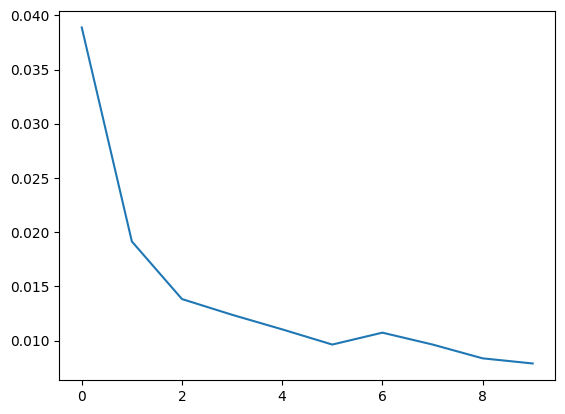

In [15]:
plt.plot(training_loss)

# evaluation

In [16]:
TEST_EPISODE_SIZE = 600

In [17]:
TEST_LANGUAGES

['Angelic',
 'Atemayar_Qelisayer',
 'Atlantean',
 'Aurek-Besh',
 'Avesta',
 'Ge_ez',
 'Glagolitic',
 'Gurmukhi',
 'Kannada',
 'Keble',
 'Malayalam',
 'Manipuri',
 'Mongolian',
 'Old_Church_Slavonic_(Cyrillic)',
 'Oriya',
 'Sylheti',
 'Syriac_(Serto)',
 'Tengwar',
 'Tibetan',
 'ULOG']

## episode

### 1 shot

In [22]:
test_dataset = OmniglotSet(
    data_path,
    train=False,
    transform=preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=1,
    query_size=15,
    episode_size=TEST_EPISODE_SIZE,
    target_label="multiclass",
    label="idx",
)
evaluator = EpisodeEvaluator(5, DEVICE)
confusion_matrix = evaluator.run(test_dataset, model)
acc = evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [00:37<00:00, 16.13it/s]


In [23]:
acc

array(0.56806667)

### 5 shot

In [20]:
test_dataset = OmniglotSet(
    data_path,
    train=False,
    transform=preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=15,
    episode_size=TEST_EPISODE_SIZE,
    target_label="multiclass",
    label="idx",
)
evaluator = EpisodeEvaluator(5, DEVICE)
confusion_matrix = evaluator.run(test_dataset, model)
acc = evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [00:40<00:00, 14.94it/s]


In [21]:
acc

array(0.9846)

## average languages

### 5 shot

In [24]:
accs = []

for lang in TEST_LANGUAGES:
    way_size = len(OmniglotSet(data_path, train=False, languages=(lang),).char_paths)
    test_dataset = OmniglotSet(
        data_path,
        train=False,
        languages=(lang),
        transform=preprocess,
        enable_episode=True,
        way_size=way_size,
        shot_size=5,
        query_size=15,
        episode_size=TEST_EPISODE_SIZE,
        target_label="multiclass",
        label="idx",
    )
    evaluator = EpisodeEvaluator(way_size, DEVICE)
    confusion_matrix = evaluator.run(test_dataset, model)
    acc = evaluator.get_total_accuracy(confusion_matrix)
    
    accs.append(acc)

100%|██████████| 600/600 [03:34<00:00,  2.80it/s]


In [25]:
np.mean(accs)

np.float64(0.5514612213075932)

In [26]:
print(f"{'lang':>50}   acc")
print("-" * 80)
for lang, acc in zip(TEST_LANGUAGES, accs):
    print(f"{lang:>50}   {acc.round(4)}")

                                              lang   acc
--------------------------------------------------------------------------------
                                           Angelic   0.5985
                                Atemayar_Qelisayer   0.5676
                                         Atlantean   0.5902
                                        Aurek-Besh   0.6091
                                            Avesta   0.5687
                                             Ge_ez   0.5626
                                        Glagolitic   0.5443
                                          Gurmukhi   0.5034
                                           Kannada   0.4629
                                             Keble   0.5935
                                         Malayalam   0.5196
                                          Manipuri   0.5631
                                         Mongolian   0.589
                    Old_Church_Slavonic_(Cyrillic)   0.5882
                       

# Save

In [27]:
model_path = artifact_path / "relation.pth"

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Visualization

In [30]:
from torchvision.datasets import ImageFolder

In [31]:
viz_preprocess = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [32]:
viz_dataset = ImageFolder(
    data_path.joinpath("omniglot-py").joinpath("images_evaluation").joinpath(TEST_LANGUAGES[8]).as_posix(),
    transform=viz_preprocess,
)
viz_dataset

Dataset ImageFolder
    Number of datapoints: 820
    Root location: ../../data/omniglot-py/images_evaluation/Kannada
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [33]:
model.eval()
with torch.no_grad():
    embed = []
    color = []
    for img, label in tqdm(viz_dataset):
        img = img.to(DEVICE)
        output = model.feature_extract(img.view(1, *img.shape))
        embed.append(output)
        color.append(label)

embed = torch.cat(embed)
color = torch.LongTensor(color)

100%|██████████| 820/820 [00:01<00:00, 530.84it/s]


In [34]:
embed.shape, color.shape

(torch.Size([820, 64, 7, 7]), torch.Size([820]))

In [35]:
from sklearn.decomposition import PCA

In [36]:
embed_model = PCA(2)
embedding = embed_model.fit_transform(embed.flatten(1, -1).detach().cpu().numpy())

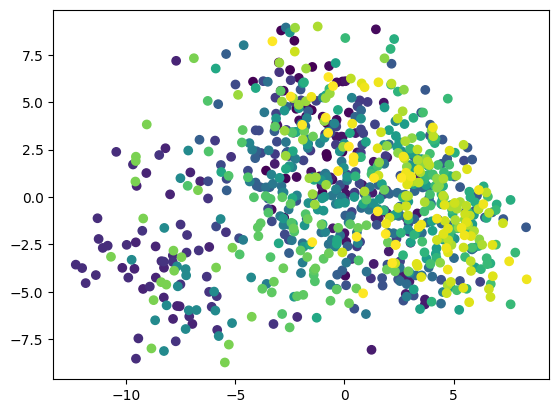

In [37]:
plt.scatter(*embedding.T, c=color)